In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
  !git clone https://github.com/mahynski/chemometrics.git
  !cd chemometrics; pip install -r requirements.txt
else:
  import sys
  sys.path.append('../../')

import chemometrics

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

fatal: destination path 'chemometrics' already exists and is not an empty directory.


In [2]:
import imblearn
import sklearn

from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd

Overview
-------------
This is a simple example of using DD-SIMCA to do some analysis.

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.144+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

watermark : 2.3.0
pandas    : 1.3.5
numpy     : 1.19.5
IPython   : 5.5.0
matplotlib: 3.2.2
imblearn  : 0.0
sklearn   : 0.0



# Load the Data

In [4]:
# Let's load some data from the tests/ for this example
if using_colab:
    loc = 'https://raw.githubusercontent.com/mahynski/chemometrics/master/tests/data/simca_train.csv'
else:
    loc = '../tests/data/simca_train.csv'
df = pd.read_csv(loc)

In [5]:
# You can see that samples are rows, columns are different features
df.head()

,Group,Class,Name,3999,3991,3983,3975,3967,3959,3951,3943,3935,3927,3919,3911,3903,3895,3887,3879,3871,3863,3855,3847,3839,3831,3823,3815,3807,3799,3791,3783,3775,3767,3759,3751,3743,3735,3727,3719,3711,...,767,759,751,743,735,727,719,711,703,695,687,679,671,663,655,647,639,631,623,615,607,599,591,583,575,567,559,551,543,535,527,519,511,503,495,487,479,471,463,455
0,1,Pure,F 16 08 001 D,-0.968873,-0.969487,-0.970409,-0.969794,-0.970101,-0.971944,-0.970409,-0.972559,-0.972866,-0.972866,-0.974095,-0.975323,-0.981774,-0.978702,-0.980853,-0.978088,-0.982696,-0.981160,-0.988532,-0.981160,-0.985153,-0.983003,-0.984232,-0.980545,-0.983310,-0.983310,-0.979317,-0.978702,-0.980238,-0.979931,-0.983310,-0.990068,-0.988225,-0.988532,-0.983617,-0.979931,-0.980545,...,0.868078,0.943031,1.028427,1.098773,1.144235,1.208129,1.319637,1.442202,1.569068,1.641563,1.714366,1.801298,1.863042,1.892532,1.910962,1.950589,1.991138,2.047659,2.131213,2.207394,2.265759,2.333031,2.386788,2.451297,2.493995,2.528092,2.548059,2.584306,2.630998,2.634070,2.629155,2.652808,2.665095,2.684140,2.700114,2.693664,2.721617,2.728067,2.718238,2.668986
1,1,Pure,F 16 08 002 D,-0.965464,-0.964848,-0.965464,-0.966697,-0.966389,-0.968238,-0.968546,-0.969778,-0.969162,-0.970087,-0.972243,-0.971011,-0.973476,-0.974708,-0.972860,-0.974400,-0.973476,-0.976866,-0.974708,-0.975017,-0.974709,-0.975017,-0.976249,-0.975325,-0.974400,-0.975017,-0.976557,-0.975633,-0.975325,-0.977482,-0.977174,-0.975017,-0.981179,-0.986726,-0.985801,-0.979331,-0.979331,...,0.853155,0.936044,1.021397,1.092577,1.137256,1.201657,1.320289,1.438613,1.577583,1.649996,1.727029,1.824400,1.881097,1.922079,1.937486,1.973846,2.014828,2.090630,2.163658,2.236378,2.302936,2.372882,2.429887,2.474875,2.501684,2.568857,2.605834,2.642501,2.680094,2.673932,2.669310,2.672083,2.703205,2.711524,2.749117,2.733402,2.765756,2.758977,2.775000,2.714092
2,1,Pure,F 16 08 003 D,-0.968031,-0.969617,-0.968665,-0.970568,-0.970568,-0.970568,-0.971203,-0.973106,-0.971203,-0.971837,-0.972472,-0.973740,-0.975961,-0.973740,-0.973740,-0.976595,-0.976278,-0.978816,-0.978498,-0.978498,-0.980084,-0.978816,-0.981353,-0.978181,-0.978181,-0.979450,-0.976278,-0.978181,-0.978181,-0.978181,-0.979450,-0.978815,-0.977229,-0.979767,-0.980719,-0.977547,-0.974692,...,0.873576,0.952557,1.044859,1.111151,1.133038,1.219314,1.348727,1.464502,1.594867,1.670992,1.738554,1.821023,1.871457,1.911422,1.921256,1.955195,1.996113,2.041471,2.126795,2.189281,2.266042,2.312668,2.354855,2.391966,2.423051,2.461431,2.472216,2.504886,2.546756,2.532165,2.538191,2.525503,2.544218,2.570861,2.570544,2.567690,2.566421,2.566739,2.547390,2.592536
3,1,Pure,F 16 08 005 D,-0.957622,-0.957622,-0.958654,-0.958654,-0.960374,-0.959686,-0.957622,-0.958654,-0.959342,-0.957622,-0.958998,-0.959342,-0.958998,-0.961406,-0.961406,-0.962782,-0.962782,-0.965878,-0.964502,-0.965878,-0.967254,-0.966910,-0.966566,-0.970006,-0.969662,-0.970006,-0.969662,-0.970006,-0.970350,-0.967942,-0.969318,-0.965534,-0.966222,-0.967598,-0.970694,-0.972414,-0.972070,...,0.854969,0.930995,1.019062,1.094056,1.132930,1.196571,1.318007,1.442539,1.580143,1.646193,1.721531,1.810974,1.875648,1.900416,1.917961,1.952018,1.987796,2.057286,2.140880,2.213810,2.283988,2.347630,2.394759,2.442577,2.498994,2.512067,2.546468,2.579838,2.616302,2.615614,2.626278,2.622494,2.646919,2.666528,2.685448,2.685792,2.708497,2.693705,2.689920,2.707809
4,1,Pure,F 16 08 006 D,-0.960211,-0.961166,-0.961166,-0.961803,-0.961803,-0.962758,-0.963713,-0.962758,-0.964350,-0.967852,-0.965942,-0.966579,-0.967534,-0.968171,-0.968489,-0.970717,-0.972309,-0.973901,-0.971036,-0.972946,-0.973583,-0.972627,-0.975174,-0.971991,-0.974219,-0.975811,-0.972946,-0.974219,-0.972309,-0.972946,-0.974856,-0.974538,-0.978995,-0.981860,-0.978358,-0.977721,-0.977721,...,0.875477,0.947746,1.036888,1.106928,1.147678,1.220583,1.346338,1.474638,1.611534,1.686032,1.768488,1.857630,1.926079,1.954413,1.984339,2.007580,2.055335,2.126648,2.205921,2.270549,2.333904,2.406808,2.461885,2

In [6]:
raw_x = np.array(df.values[:,3:], dtype=float) # Extract features
raw_y = np.array(df['Class'].values, dtype=str) # Take the class as the target

# Model the Data with DD-SIMCA

In [7]:
from chemometrics.classifier.simca import DDSIMCA_Model

## Training

In [8]:
# Here the data is spectra so we will not scale the X data
dds = DDSIMCA_Model(n_components=7, alpha=0.05, gamma=0.01, scale_x=False)

In [9]:
_ = dds.fit(raw_x, raw_y)

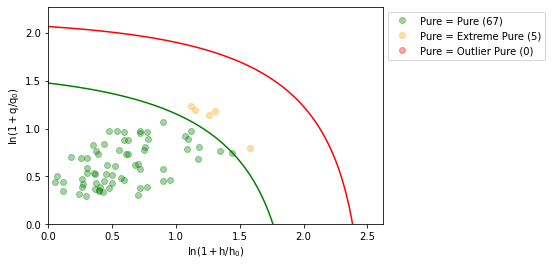

In [10]:
_ = dds.visualize(raw_x, raw_y)

In [11]:
# We can see what samples are classified as 'Pure' using the predict() function.
pure_sample_mask = dds.predict(raw_x)
len(pure_sample_mask)

72

In [12]:
# We could extract that data as follows:
pure = raw_x[pure_sample_mask]

In [13]:
# Extremes and Outliers can be found using the check_outliers() function.
extremes_mask, outliers_mask = dds.check_outliers(raw_x)

In [14]:
# We could extract that data as follows:
extremes = raw_x[extremes_mask]
outliers = raw_x[outliers_mask]

In [15]:
# Number of outliers, for example?
np.sum(outliers_mask)

0

In [16]:
# Number of extremes, for example?
np.sum(extremes_mask)

5

## Testing

First, let's test on other pure samples that weren't in the training set.

In [17]:
if using_colab:
    loc = 'https://raw.githubusercontent.com/mahynski/chemometrics/master/tests/data/simca_test.csv'
else:
    loc = '../tests/data/simca_test.csv'
df = pd.read_csv(loc)

raw_x_t = np.array(df.values[:,3:], dtype=float)
raw_y_t = np.array(df.values[:,1], dtype=str)

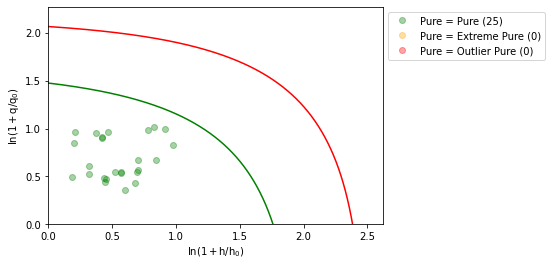

In [18]:
# Here, we would like to see all the points fall INSIDE the green acceptance region since we know they
# all belong to the 'Pure' class.
_ = dds.visualize(raw_x_t, raw_y_t)

We could also check against known alternates.

In [19]:
if using_colab:
    loc = 'https://raw.githubusercontent.com/mahynski/chemometrics/master/tests/data/simca_test_alt.csv'
else:
    loc = '../tests/data/simca_test_alt.csv'
df = pd.read_csv(loc, header=None)

raw_x_a = np.array(df.values[:,3:], dtype=float)
raw_y_a = np.array(df.values[:,1], dtype=str)

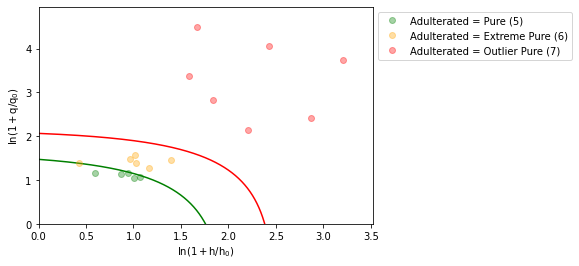

In [20]:
# Here, we would like to see all the points fall OUTSIDE the green acceptance region since we know they
# are not the 'Pure' class.
_ = dds.visualize(raw_x_a, raw_y_a)

# Create a Classifier

In the last section, we just created a DD-SIMCA Model. In practice, we would like to turn that into a classifier.  

In [21]:
from chemometrics.classifier.simca import SIMCA_Classifier

In [22]:
sc = SIMCA_Classifier(n_components=7, 
                      alpha=0.05, 
                      scale_x=False, 
                      style='dd-simca', 
                      target_class='Pure', 
                      use='TEFF')

In [23]:
# Combine the training (all Pure) and alternate data to create a new training set that has multiple (in this
# case 2) classes.  We specified the target_class='Pure' above, which tells the classifier that we are trying
# to model that class.  ONLY that data is used to fit the model; all other classes it is provided will be
# ignored.
x_train = np.vstack((raw_x, raw_x_a))
y_train = np.hstack((raw_y, raw_y_a))
_ = sc.fit(x_train, y_train)

In [24]:
# By default, TEFF is used to score the classifer, you can change this when then classifier is instantiated.
sc.score(x_train, y_train) # TEFF = sqrt(TSNS * TSPS)

0.8197974757429837

In [25]:
sc.TSNS, sc.TSPS, sc.TEFF

(0.9305555555555556, 0.7222222222222222, 0.8197974757429837)

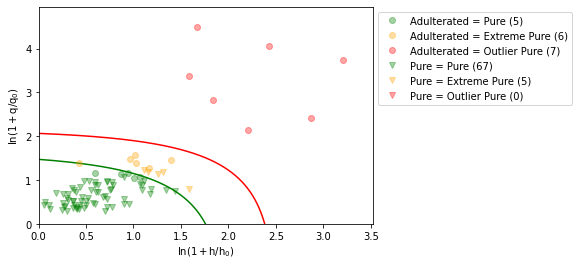

In [26]:
# Look at all the data.
sc.model.visualize(x_train, y_train)

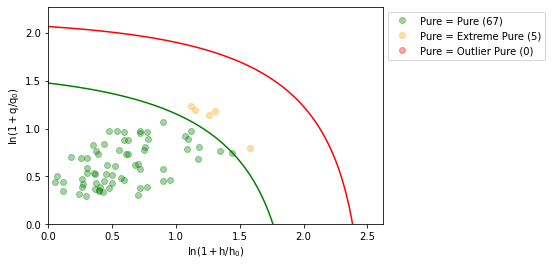

In [27]:
# Look at just the data used to train the underlying SIMCA_Model.
sc.model.visualize(raw_x, raw_y)

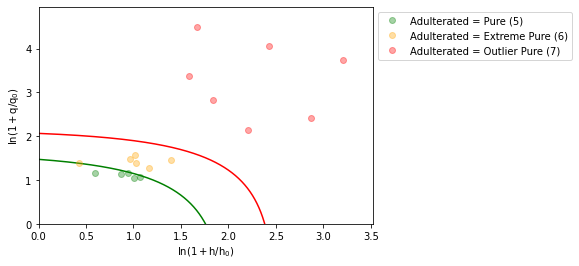

In [28]:
# Look at the data used to test how well the model performs by classifying alternative samples.
sc.model.visualize(raw_x_a, raw_y_a)

# Optimizing the Classifier

Here we took alpha as a meaningful choice of type I error rate, but it could also be adjusted.  Moreover, we arbitrarily selected the number of PCs to use in the SIMCA model.  We can use scikit-learn's pipelines to automatically optimize hyperparameters like this.

In [29]:
# Here I've use an imblearn pipeline, but you can also use scikit-learn's pipeline if you don't want to 
# do any class balancing.

pipeline = imblearn.pipeline.Pipeline(steps=[
    # Insert other preprocessing steps here...
    # ("smote", ScaledSMOTEENN(random_state=1)), # For example, class balancing
    ("simca", SIMCA_Classifier(n_components=7, 
                               alpha=0.05, 
                               scale_x=False, 
                               style='dd-simca', 
                               target_class='Pure', 
                               use='TEFF')
    )
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
param_grid = [{
    # 'smote__k_enn':[1, 2, 3],
    # 'smote__k_smote':[1, 3, 3],
    # 'smote__kind_sel_enn':['all', 'mode'],
    'simca__n_components':np.arange(1, 10),
    # 'simca__alpha':[0.07, 0.05, 0.03, 0.01],
    # 'simca__style':['dd-simca', 'simca'],
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

_ = gs.fit(x_train, y_train)

In [30]:
# The best parameters found can be accessed like this:
gs.best_params_

{'simca__n_components': 6}

In [31]:
gs.best_score_ # The best score it recieved was...

0.8413590987427072

In [32]:
# You can see detailed CV results here
gs.cv_results_

{'mean_fit_time': array([0.37537511, 0.24159837, 0.4757123 , 0.35449584, 0.27398086,
        0.23110263, 0.26442663, 0.24256651, 0.18935204]),
 'mean_score_time': array([0.00827599, 0.00502022, 0.01349831, 0.00616829, 0.01188103,
        0.00263453, 0.00404477, 0.00475184, 0.00273752]),
 'mean_test_score': array([0.47322449, 0.54083337, 0.59792034, 0.69443473, 0.73210096,
        0.8413591 , 0.7983953 , 0.80695493, 0.75707794]),
 'param_simca__n_components': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'simca__n_components': 1},
  {'simca__n_components': 2},
  {'simca__n_components': 3},
  {'simca__n_components': 4},
  {'simca__n_components': 5},
  {'simca__n_components': 6},
  {'simca__n_components': 7},
  {'simca__n_components': 8},
  {'simca__n_components': 9}],
 'rank_test_score': array([9, 8, 7, 6, 5, 1, 3, 2, 4]

Text(0, 0.5, 'Mean Test Score (TEFF)')

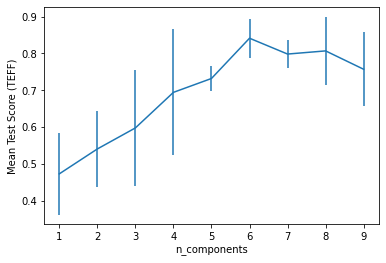

In [33]:
# For a 1D optimization you can easily visualize where the best value is
plt.errorbar(np.arange(1, 10), gs.cv_results_['mean_test_score'], yerr=gs.cv_results_['std_test_score'])
plt.xlabel('n_components')
plt.ylabel('Mean Test Score (TEFF)')

In [34]:
# The refit=True (default) refits the model on the data in the end so you can use it directly.
gs.best_estimator_.predict(raw_x) # raw_x was just Pure

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True])

In [35]:
gs.best_estimator_.predict(raw_x_a) # raw_x_a was just Alternates

array([ True, False, False,  True, False, False,  True,  True, False,
        True, False, False, False, False, False,  True, False, False])

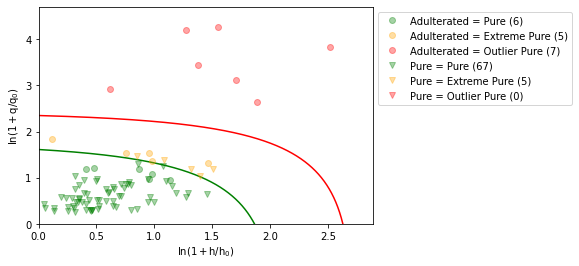

In [36]:
gs.best_estimator_.named_steps['simca'].model.visualize(x_train, y_train)

In [37]:
gs.best_estimator_.named_steps['simca'].score(x_train, y_train) # The score being used here is TEFF

0.7876359377087682

In [38]:
gs.best_estimator_.named_steps['simca'].TSNS # 67 / (67+5)

0.9305555555555556

In [39]:
gs.best_estimator_.named_steps['simca'].TSPS # 1 - 6/(6+5+7)

0.6666666666666667

In [40]:
gs.best_estimator_.named_steps['simca'].TEFF # sqrt(TSPS*TSNS)

0.7876359377087682